[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15105006\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


count    500.000000
mean      -0.972000
std        0.142325
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max        1.000000
Name: Sentiment, dtype: float64


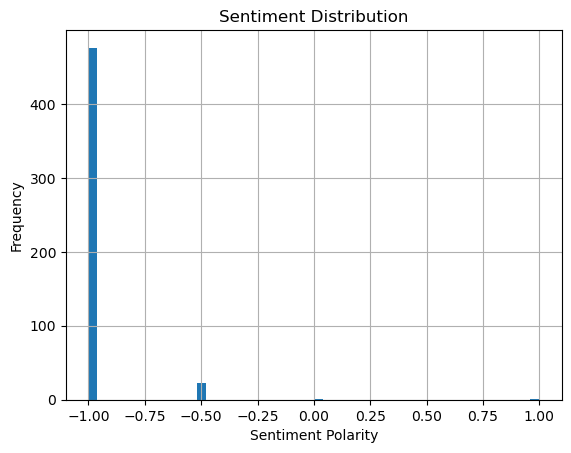

In [31]:
import pandas as pd
import nltk
import requests
import string
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Download necessary NLTK resources
nltk.download('punkt')

# Load Irish stop words from spaCy GitHub repository
stop_words_url = 'https://raw.githubusercontent.com/explosion/spaCy/master/spacy/lang/ga/stop_words.py'
response = requests.get(stop_words_url)
exec(response.text)
irish_stop_words = STOP_WORDS  # This should be a set of stop words

# Load the CSV file
file_path = 'duchas_stories_irish.csv'
irish_stories = pd.read_csv(file_path)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove special characters and digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Tokenize
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in irish_stop_words]
    # Join words back to a single string
    return ' '.join(words)

# Apply preprocessing
irish_stories['Transcription'] = irish_stories['Transcription'].apply(preprocess_text)

# Load the pre-trained model and tokenizer for sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Function to get sentiment polarity score
def get_sentiment_score(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']
    score = result['score']
    # Convert label to a numerical score
    label_to_score = {'1 star': -1, '2 stars': -0.5, '3 stars': 0, '4 stars': 0.5, '5 stars': 1}
    return label_to_score[label]

# Apply sentiment analysis
irish_stories['Sentiment'] = irish_stories['Transcription'].apply(get_sentiment_score)

# Analyze and visualize results
print(irish_stories['Sentiment'].describe())

# Plot sentiment distribution
irish_stories['Sentiment'].hist(bins=50)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Save the results
irish_stories.to_csv('irish_stories_with_sentiment_scores.csv', index=False)
